<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB2] - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first classification of our traffic signs
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :** To be able to use this notebook and the following, **you must have generated the enhanced datasets** in <dataset_dir>/enhanced via the notebook **[01-Preparation-of-data.ipynb](01-Preparation-of-data.ipynb)**  

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB2.001'
datasets_dir = pwk.init('GTSRB2', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB2_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : GTSRB2
Run time             : Wednesday 10 February 2021, 09:16:51
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB2_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB2_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

# enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:01 659ms)


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


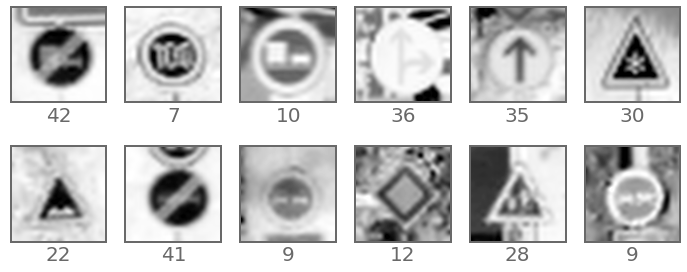

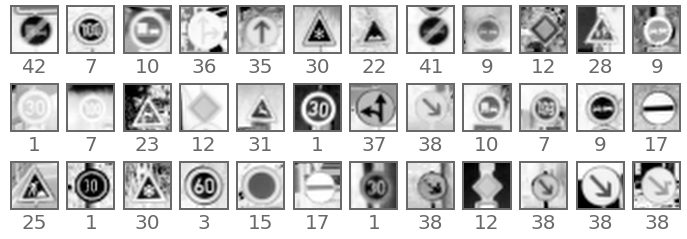

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [6]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

**Train it :**

In [9]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (x_test, y_test))

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 27:24 - loss: 3.7783 - accuracy: 0.0000e+00

 20/613 [..............................] - ETA: 1s - loss: 3.6197 - accuracy: 0.0545       

 40/613 [>.............................] - ETA: 1s - loss: 3.5682 - accuracy: 0.0603

 60/613 [=>............................] - ETA: 1s - loss: 3.5394 - accuracy: 0.0675

 80/613 [==>...........................] - ETA: 1s - loss: 3.5032 - accuracy: 0.0780

100/613 [===>..........................] - ETA: 1s - loss: 3.4586 - accuracy: 0.0917

121/613 [====>.........................] - ETA: 1s - loss: 3.3996 - accuracy: 0.1083

142/613 [=====>........................] - ETA: 1s - loss: 3.3318 - accuracy: 0.1262

163/613 [======>.......................] - ETA: 1s - loss: 3.2602 - accuracy: 0.1444

184/613 [========>.....................] - ETA: 1s - loss: 3.1870 - accuracy: 0.1625

205/613 [=========>....................] - ETA: 1s - loss: 3.1140 - accuracy: 0.1805

226/613 [==========>...................] - ETA: 0s - loss: 3.0423 - accuracy: 0.1982

247/613 [===========>..................] - ETA: 0s - loss: 2.9729 - accuracy: 0.2153

268/613 [============>.................] - ETA: 0s - loss: 2.9062 - accuracy: 0.2318

289/613 [=============>................] - ETA: 0s - loss: 2.8425 - accuracy: 0.2475

310/613 [==============>...............] - ETA: 0s - loss: 2.7815 - accuracy: 0.2626

331/613 [===============>..............] - ETA: 0s - loss: 2.7232 - accuracy: 0.2770

352/613 [================>.............] - ETA: 0s - loss: 2.6675 - accuracy: 0.2908

373/613 [=================>............] - ETA: 0s - loss: 2.6142 - accuracy: 0.3042

394/613 [==================>...........] - ETA: 0s - loss: 2.5632 - accuracy: 0.3170

415/613 [===================>..........] - ETA: 0s - loss: 2.5144 - accuracy: 0.3293

436/613 [====================>.........] - ETA: 0s - loss: 2.4677 - accuracy: 0.3411

457/613 [=====================>........] - ETA: 0s - loss: 2.4229 - accuracy: 0.3524

478/613 [======================>.......] - ETA: 0s - loss: 2.3802 - accuracy: 0.3633

499/613 [=======================>......] - ETA: 0s - loss: 2.3392 - accuracy: 0.3737

520/613 [========================>.....] - ETA: 0s - loss: 2.3001 - accuracy: 0.3837

541/613 [=========================>....] - ETA: 0s - loss: 2.2625 - accuracy: 0.3933

562/613 [==========================>...] - ETA: 0s - loss: 2.2264 - accuracy: 0.4026

583/613 [===========================>..] - ETA: 0s - loss: 2.1917 - accuracy: 0.4115

603/613 [============================>.] - ETA: 0s - loss: 2.1599 - accuracy: 0.4197

613/613 [==============================] - ETA: 0s - loss: 2.1444 - accuracy: 0.4237

613/613 [==============================] - 5s 4ms/step - loss: 2.1429 - accuracy: 0.4241 - val_loss: 0.4413 - val_accuracy: 0.8910


Epoch 2/5
  1/613 [..............................] - ETA: 1s - loss: 0.4427 - accuracy: 0.8594

 21/613 [>.............................] - ETA: 1s - loss: 0.3586 - accuracy: 0.9007

 41/613 [=>............................] - ETA: 1s - loss: 0.3452 - accuracy: 0.9038

 61/613 [=>............................] - ETA: 1s - loss: 0.3365 - accuracy: 0.9051

 82/613 [===>..........................] - ETA: 1s - loss: 0.3294 - accuracy: 0.9065

102/613 [===>..........................] - ETA: 1s - loss: 0.3241 - accuracy: 0.9074

122/613 [====>.........................] - ETA: 1s - loss: 0.3193 - accuracy: 0.9083

143/613 [=====>........................] - ETA: 1s - loss: 0.3150 - accuracy: 0.9093

163/613 [======>.......................] - ETA: 1s - loss: 0.3112 - accuracy: 0.9103

183/613 [=======>......................] - ETA: 1s - loss: 0.3076 - accuracy: 0.9113

203/613 [========>.....................] - ETA: 1s - loss: 0.3042 - accuracy: 0.9123

224/613 [=========>....................] - ETA: 0s - loss: 0.3012 - accuracy: 0.9131

244/613 [==========>...................] - ETA: 0s - loss: 0.2986 - accuracy: 0.9139

264/613 [===========>..................] - ETA: 0s - loss: 0.2965 - accuracy: 0.9146

284/613 [============>.................] - ETA: 0s - loss: 0.2945 - accuracy: 0.9152

304/613 [=============>................] - ETA: 0s - loss: 0.2924 - accuracy: 0.9159

324/613 [==============>...............] - ETA: 0s - loss: 0.2904 - accuracy: 0.9165

344/613 [===============>..............] - ETA: 0s - loss: 0.2885 - accuracy: 0.9171

364/613 [================>.............] - ETA: 0s - loss: 0.2865 - accuracy: 0.9176

384/613 [=================>............] - ETA: 0s - loss: 0.2846 - accuracy: 0.9181

404/613 [==================>...........] - ETA: 0s - loss: 0.2827 - accuracy: 0.9187

424/613 [===================>..........] - ETA: 0s - loss: 0.2809 - accuracy: 0.9192

444/613 [====================>.........] - ETA: 0s - loss: 0.2792 - accuracy: 0.9197

464/613 [=====================>........] - ETA: 0s - loss: 0.2774 - accuracy: 0.9202

484/613 [======================>.......] - ETA: 0s - loss: 0.2757 - accuracy: 0.9207

504/613 [=======================>......] - ETA: 0s - loss: 0.2741 - accuracy: 0.9212

524/613 [========================>.....] - ETA: 0s - loss: 0.2724 - accuracy: 0.9217

544/613 [=========================>....] - ETA: 0s - loss: 0.2708 - accuracy: 0.9222

564/613 [==========================>...] - ETA: 0s - loss: 0.2693 - accuracy: 0.9227

584/613 [===========================>..] - ETA: 0s - loss: 0.2677 - accuracy: 0.9231

604/613 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.9236

613/613 [==============================] - 2s 3ms/step - loss: 0.2655 - accuracy: 0.9238 - val_loss: 0.3227 - val_accuracy: 0.9194


Epoch 3/5
  1/613 [..............................] - ETA: 1s - loss: 0.1368 - accuracy: 0.9531

 22/613 [>.............................] - ETA: 1s - loss: 0.1582 - accuracy: 0.9570

 43/613 [=>............................] - ETA: 1s - loss: 0.1483 - accuracy: 0.9576

 64/613 [==>...........................] - ETA: 1s - loss: 0.1430 - accuracy: 0.9582

 85/613 [===>..........................] - ETA: 1s - loss: 0.1407 - accuracy: 0.9588

106/613 [====>.........................] - ETA: 1s - loss: 0.1392 - accuracy: 0.9595

127/613 [=====>........................] - ETA: 1s - loss: 0.1379 - accuracy: 0.9602

148/613 [======>.......................] - ETA: 1s - loss: 0.1369 - accuracy: 0.9607

169/613 [=======>......................] - ETA: 1s - loss: 0.1363 - accuracy: 0.9608

190/613 [========>.....................] - ETA: 1s - loss: 0.1362 - accuracy: 0.9608

211/613 [=========>....................] - ETA: 0s - loss: 0.1358 - accuracy: 0.9608

232/613 [==========>...................] - ETA: 0s - loss: 0.1354 - accuracy: 0.9608

253/613 [===========>..................] - ETA: 0s - loss: 0.1351 - accuracy: 0.9608

274/613 [============>.................] - ETA: 0s - loss: 0.1349 - accuracy: 0.9608

295/613 [=============>................] - ETA: 0s - loss: 0.1348 - accuracy: 0.9607

316/613 [==============>...............] - ETA: 0s - loss: 0.1347 - accuracy: 0.9607

337/613 [===============>..............] - ETA: 0s - loss: 0.1345 - accuracy: 0.9607

358/613 [================>.............] - ETA: 0s - loss: 0.1344 - accuracy: 0.9606

379/613 [=================>............] - ETA: 0s - loss: 0.1342 - accuracy: 0.9606

400/613 [==================>...........] - ETA: 0s - loss: 0.1339 - accuracy: 0.9606

421/613 [===================>..........] - ETA: 0s - loss: 0.1337 - accuracy: 0.9607

442/613 [====================>.........] - ETA: 0s - loss: 0.1334 - accuracy: 0.9607

463/613 [=====================>........] - ETA: 0s - loss: 0.1330 - accuracy: 0.9608

484/613 [======================>.......] - ETA: 0s - loss: 0.1327 - accuracy: 0.9609

505/613 [=======================>......] - ETA: 0s - loss: 0.1324 - accuracy: 0.9609

526/613 [========================>.....] - ETA: 0s - loss: 0.1322 - accuracy: 0.9610

547/613 [=========================>....] - ETA: 0s - loss: 0.1319 - accuracy: 0.9611

568/613 [==========================>...] - ETA: 0s - loss: 0.1317 - accuracy: 0.9611

589/613 [===========================>..] - ETA: 0s - loss: 0.1315 - accuracy: 0.9612

610/613 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9612

613/613 [==============================] - 2s 3ms/step - loss: 0.1312 - accuracy: 0.9613 - val_loss: 0.2666 - val_accuracy: 0.9339


Epoch 4/5
  1/613 [..............................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9688

 22/613 [>.............................] - ETA: 1s - loss: 0.0856 - accuracy: 0.9705

 43/613 [=>............................] - ETA: 1s - loss: 0.0895 - accuracy: 0.9694

 64/613 [==>...........................] - ETA: 1s - loss: 0.0924 - accuracy: 0.9688

 85/613 [===>..........................] - ETA: 1s - loss: 0.0934 - accuracy: 0.9688

106/613 [====>.........................] - ETA: 1s - loss: 0.0943 - accuracy: 0.9689

127/613 [=====>........................] - ETA: 1s - loss: 0.0950 - accuracy: 0.9690

148/613 [======>.......................] - ETA: 1s - loss: 0.0953 - accuracy: 0.9691

169/613 [=======>......................] - ETA: 1s - loss: 0.0953 - accuracy: 0.9694

190/613 [========>.....................] - ETA: 1s - loss: 0.0953 - accuracy: 0.9695

211/613 [=========>....................] - ETA: 0s - loss: 0.0952 - accuracy: 0.9697

232/613 [==========>...................] - ETA: 0s - loss: 0.0950 - accuracy: 0.9700

253/613 [===========>..................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9702

274/613 [============>.................] - ETA: 0s - loss: 0.0945 - accuracy: 0.9704

295/613 [=============>................] - ETA: 0s - loss: 0.0942 - accuracy: 0.9705

316/613 [==============>...............] - ETA: 0s - loss: 0.0940 - accuracy: 0.9707

337/613 [===============>..............] - ETA: 0s - loss: 0.0937 - accuracy: 0.9708

358/613 [================>.............] - ETA: 0s - loss: 0.0935 - accuracy: 0.9710

379/613 [=================>............] - ETA: 0s - loss: 0.0932 - accuracy: 0.9711

400/613 [==================>...........] - ETA: 0s - loss: 0.0930 - accuracy: 0.9712

421/613 [===================>..........] - ETA: 0s - loss: 0.0927 - accuracy: 0.9713

442/613 [====================>.........] - ETA: 0s - loss: 0.0924 - accuracy: 0.9715

463/613 [=====================>........] - ETA: 0s - loss: 0.0922 - accuracy: 0.9716

484/613 [======================>.......] - ETA: 0s - loss: 0.0919 - accuracy: 0.9717

505/613 [=======================>......] - ETA: 0s - loss: 0.0917 - accuracy: 0.9718

526/613 [========================>.....] - ETA: 0s - loss: 0.0915 - accuracy: 0.9719

547/613 [=========================>....] - ETA: 0s - loss: 0.0913 - accuracy: 0.9720

568/613 [==========================>...] - ETA: 0s - loss: 0.0910 - accuracy: 0.9720

589/613 [===========================>..] - ETA: 0s - loss: 0.0908 - accuracy: 0.9721

610/613 [============================>.] - ETA: 0s - loss: 0.0906 - accuracy: 0.9722

613/613 [==============================] - 2s 3ms/step - loss: 0.0906 - accuracy: 0.9722 - val_loss: 0.2548 - val_accuracy: 0.9393


Epoch 5/5
  1/613 [..............................] - ETA: 1s - loss: 0.0345 - accuracy: 0.9844

 22/613 [>.............................] - ETA: 1s - loss: 0.0591 - accuracy: 0.9813

 43/613 [=>............................] - ETA: 1s - loss: 0.0603 - accuracy: 0.9824

 64/613 [==>...........................] - ETA: 1s - loss: 0.0621 - accuracy: 0.9819

 85/613 [===>..........................] - ETA: 1s - loss: 0.0634 - accuracy: 0.9814

106/613 [====>.........................] - ETA: 1s - loss: 0.0645 - accuracy: 0.9808

127/613 [=====>........................] - ETA: 1s - loss: 0.0652 - accuracy: 0.9806

148/613 [======>.......................] - ETA: 1s - loss: 0.0656 - accuracy: 0.9805

169/613 [=======>......................] - ETA: 1s - loss: 0.0658 - accuracy: 0.9804

190/613 [========>.....................] - ETA: 1s - loss: 0.0658 - accuracy: 0.9804

211/613 [=========>....................] - ETA: 0s - loss: 0.0656 - accuracy: 0.9805

232/613 [==========>...................] - ETA: 0s - loss: 0.0655 - accuracy: 0.9805

253/613 [===========>..................] - ETA: 0s - loss: 0.0654 - accuracy: 0.9805

274/613 [============>.................] - ETA: 0s - loss: 0.0655 - accuracy: 0.9805

295/613 [=============>................] - ETA: 0s - loss: 0.0656 - accuracy: 0.9805

316/613 [==============>...............] - ETA: 0s - loss: 0.0657 - accuracy: 0.9805

337/613 [===============>..............] - ETA: 0s - loss: 0.0658 - accuracy: 0.9805

358/613 [================>.............] - ETA: 0s - loss: 0.0658 - accuracy: 0.9805

379/613 [=================>............] - ETA: 0s - loss: 0.0658 - accuracy: 0.9805

400/613 [==================>...........] - ETA: 0s - loss: 0.0657 - accuracy: 0.9805

421/613 [===================>..........] - ETA: 0s - loss: 0.0657 - accuracy: 0.9806

442/613 [====================>.........] - ETA: 0s - loss: 0.0656 - accuracy: 0.9806

463/613 [=====================>........] - ETA: 0s - loss: 0.0656 - accuracy: 0.9806

484/613 [======================>.......] - ETA: 0s - loss: 0.0656 - accuracy: 0.9806

505/613 [=======================>......] - ETA: 0s - loss: 0.0656 - accuracy: 0.9806

526/613 [========================>.....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9806

547/613 [=========================>....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9807

568/613 [==========================>...] - ETA: 0s - loss: 0.0655 - accuracy: 0.9807

589/613 [===========================>..] - ETA: 0s - loss: 0.0655 - accuracy: 0.9807

610/613 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9807

613/613 [==============================] - 2s 3ms/step - loss: 0.0654 - accuracy: 0.9807 - val_loss: 0.1967 - val_accuracy: 0.9480



Duration :  00:00:13 938ms


**Evaluate it :**

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9480


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.1967
Test accuracy  : 0.9480


In [12]:
pwk.end()

End time is : Wednesday 10 February 2021, 09:17:14
Duration is : 00:00:22 478ms
This notebook ends here


<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>